In [2]:
import numpy as np
from scipy.optimize import newton, bisect
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from sympy import *
import logging
logging.basicConfig(format='%(asctime)s %(message)s')

# mpl.rcParams['text.usetex']=True
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
    })

In [3]:
def plot3d(x, u, scheme, LAMBDA, fluxfunc='$f_1$', save=True):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$u(x,t)$')

    # plot each line on a separate plane
    n_t = len(u)
    for j in range(n_t):
        ax.plot(x, u[j], zs=T_0 + j*dt, zdir='y')
        
    ax.set_title(f"{scheme.title()} scheme, $\lambda$={LAMBDA}, flux {fluxfunc}")
    if save:
        plt.savefig(f"hw2q3-{fluxfunc}-{scheme}-{str(LAMBDA)}-3d.pdf", bbox_inches='tight')

def plot2d(x, u, scheme, LAMBDA, fluxfunc="$f_1$", save=True):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot()
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')

    # plot each line on a separate plane
    n_t = len(u)
    for t in [0.5, 1, 2]:
        j = round(t/dt)
        ax.plot(x, u[j], label=f"$t$={t}")

    ax.legend()
    ax.set_title(f"{scheme.title()} scheme, $\lambda$={LAMBDA}")
    if save:
        plt.savefig(f"hw2q3-{fluxfunc}-{scheme}-{str(LAMBDA)}-2d.pdf", bbox_inches='tight')

In [4]:
A = -1
B = +1
T_0 = 0
T = 3

LAMBDA = 0.50
c = 1
h = 0.01
dt = h*LAMBDA

n_x = int(np.abs(B-A)/h)+2
n_t = int((T - T_0)/dt)+2

x = np.linspace(A, B, n_x)
t = np.linspace(T_0, T, n_t)

## Define the derivative symbolically

In [5]:
u = symbols('u')
# f = Function('f')
f = u**2/(u**2 + 0.5*(1-u)**2)
fp = simplify(Derivative(f, u))
fpp = simplify(Derivative(fp, u))
fpl = lambdify(u, fp, "numpy")
fl = lambdify(u, f, "numpy")
fppl = lambdify(u, fpp, "numpy")
u_r = 0
u_l = 1

## Find $u^\star$

In [6]:
ustarsolves = simplify(fp) - ((f - f.subs(u, u_r))/(u - u_r))
ustarsolves = numer(ratsimp(ustarsolves))
roots = real_roots(ustarsolves)
roots

[-sqrt(3)/3, 0, sqrt(3)/3]

${\frac1{\sqrt 3}}$ is the value for $u^\star$ because that is the only root that falls between $u_l$ and $u_r$.

In [7]:
ustar = 1/np.sqrt(3)

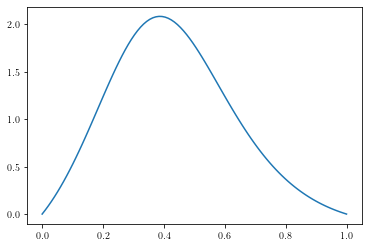

In [8]:
xx = np.linspace(0,1,100)
plt.plot(xx, fpl(xx))

In [9]:
# Initial condition
def u_0(x):
    if x <= 0:
        return 1
    elif x > 0:
        return 0

# Burgers f
def f1(u):
    return u**2/2
# Berklev f
## Could also have just used fl
def f2(u):
    return u**2/(u**2 + 0.5*(1-u)**2)

def fluxToName(flux):
    if flux == f1:
        return "Burgers' equation"
    elif flux == f2:
        return "Buckley Leverret"
    else:
        return flux.__name__
# exact solutions
def exact1(x,t):
    leftOfShock = x<(t/2)
    y = np.zeros_like(x)
    y[leftOfShock] = 1
    # y[1-leftOfShock] = 0
    return y

fpul = fpl(u_l)
fpus = fpl(ustar)

# uses newton's method to find the inverse
def fpinv_newton(xbyt):
    def fpt(u, xbyt):
        return fpl(u)-xbyt
    if xbyt < fpul or xbyt > fpus:
        raise DomainError(f"fprime inverse is only defined on [{fpul}, {fpus}], but argument is {xbyt}")
    return newton(func=(lambda u: fpl(u)-xbyt), fprime=fppl, x0=0.6, tol=1e-06, maxiter=25)
fpinv_newton_v = lambda xbyt: np.array([fpinv(r) for r in xbyt])

# Use bisection method to find the inverse
def fpinv_bisect(xbyt):
    def fpt(u, xbyt):
        return fpl(u)-xbyt
    return bisect(fpt, u_l, ustar, args=(xbyt))
fpinv_bisect_v = lambda xbyt: np.array([fpinv_bisect(r) for r in xbyt])

def exact2(x,t):
    x = np.array(x)
    y = np.copy(x)
    left = x < t * fpul
    right = x > t * fpus
    raref = np.logical_and(x>= t * fpul, x <= t * fpus)
    y[left] = u_l
    y[right] = u_r
    y[raref] = fpinv_bisect_v(x[raref]/t)
    return y


# Populate initial data

In [10]:
# returns n initial values on the interval l to r
# also returns the x
def popIC(f, l, r, n):
    xvalues = np.linspace(l,r, n)
    u = [f(x) for x in xvalues]
    return u, xvalues

# Define the general conservative form

In [11]:
def conservativeFormIterate(vn, F, LAMBDA=LAMBDA):
    n = len(vn)
    vnPlusOne = np.zeros(n-2)
    # vnPlusOne = vn[1:-1] - LAMBDA*(F(vn[1:-1], vn[2:]) - F(vn[0:-2], vn[1:-1]))
    for i in range(1,n-1):
        vnPlusOne[i-1] = vn[i] - LAMBDA*(F(vn[i], vn[i+1]) - F(vn[i-1], vn[i]))
    return vnPlusOne

## Define schemes

In [12]:
def FG1(u,v):
    # f1 is convex!
    return max(max(u,0), min(v, 0))**2/2

def FG2(u,v, f=f2):
    ## THIS ASSUMES f is convex, and has a minima at zero
    ##  and also that u,v\in [0,1] (why?)
    if (0 <= u and u <= 1 and 0 <= v and v <= 1):
        return max(max(f(u),0), min(f(v), 0))
    else:
        raise Exception("FG2 assumes u,v \in [0,1].")
def FLF(u,v,f, LAMBDA):
    return 0.5*(f(u) + f(v) - (v - u)/LAMBDA)
def FLW(u,v,f, fluxp, LAMBDA):
    return 0.5*(
        f(u) + f(v) - LAMBDA * (f(v)-f(u)) * fluxp( (u+v)/2 )
    )

# Compute function

In [13]:
def run(xvalues, initial, scheme, flux=f1, plot=True, save=False):
        u = np.zeros((n_t, n_x))
        
        # select the appropriate flux
        if scheme == 'godunov':
            F = lambda u,v: FG2(u,v, flux)
        elif scheme == 'lax-Friedrich':
            F = lambda u,v: FLF(u,v, flux, LAMBDA)
        elif scheme == 'lax-Wendroff':
            if flux == f1:
                fluxp = lambda u: u
            else:
                fluxp = fpl
            F = (lambda u,v: FLW(u,v,flux,fluxp, LAMBDA))
        else:
            raise NotImplementedError("Unknown scheme.")
        
        w0 = initial
        
        u[0] = w0[n_t:-n_t]
        # Compute j'th level by providing the j-1'th level
        w_pre = w0
        logging.info("Entering loop now")
        for j in range(1, n_t):
            w = conservativeFormIterate(w_pre, F, LAMBDA)
            u[j] = w[n_t-j:-n_t+j]
            w_pre = w
        x = xvalues[n_t:-n_t]
    
        # If asked for a plot, then plot
        if plot:
            logging.info("Plotting...")
            fluxfunc = fluxToName(flux)
            plot3d(x, u, scheme, fluxfunc=fluxfunc, LAMBDA=LAMBDA, save=save)
        return u,x

## Use same inital condition for all schemes and fluxes

In [14]:
w0, xvalues = popIC(u_0, A-n_t*h, B+n_t*h, n_x+2*n_t)
actualw0 = w0[n_t:-n_t]
actualx  = xvalues[n_t:-n_t]

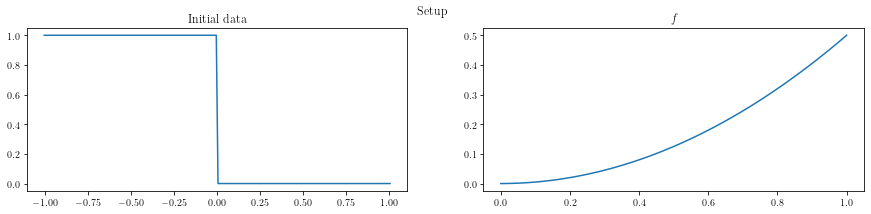

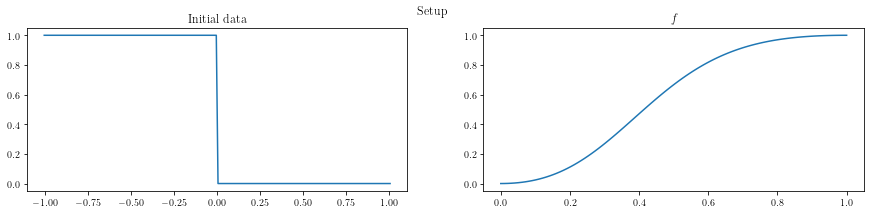

In [15]:
for f in [f1, f2]:
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,3)
    ax1.plot(actualx, actualw0)
    ax1.set_title("Initial data")
    ul_to_ur = np.linspace(0,1, 100)
    ax2.plot(ul_to_ur, f(ul_to_ur))
    ax2.set_title("$f$")
    fig.suptitle("Setup")
    plt.savefig(f"hw2q3-setup-{f.__name__}.pdf")

## Store exact solution

In [16]:
u_e1 = np.array([exact1(actualx, dt*n) for n in range(n_t)])
# plot3d(actualx, u_e1, 'Exact', LAMBDA, fluxfunc=fluxToName(f1), save=False)

In [17]:
u_e2 = np.zeros_like(u_e1)
u_e2[0] = u_e1[0]
u_e2[1:] = np.array([exact2(actualx, dt*n) for n in range(1, n_t)])
# plot3d(actualx, u_e2, 'Exact', LAMBDA, fluxfunc=fluxToName(f2), save=False)

## Compute solution for Buckley-Leverret

In [18]:
# Flux 2 runs
u_g2,_ = run(xvalues, w0, 'godunov', flux=f2, plot=False, save=False)

In [19]:
u_f2,_ = run(xvalues, w0, 'lax-Friedrich', flux=f2, plot=False, save=False)

In [20]:
u_w2,_ = run(xvalues, w0, "lax-Wendroff", flux=f2, plot=False, save=False)

## Compute solution for inviscid Burgers'

In [21]:
# Flux 1 runs
u_g1,_ = run(xvalues, w0, 'godunov', flux=f1, plot=False, save=False)

In [ ]:
u_f1,_ = run(xvalues, w0, 'lax-Friedrich', flux=f1, plot=False, save=False)

In [ ]:
u_w1,_ = run(xvalues, w0, "lax-Wendroff", flux=f1, plot=False, save=False)

## Produce plots

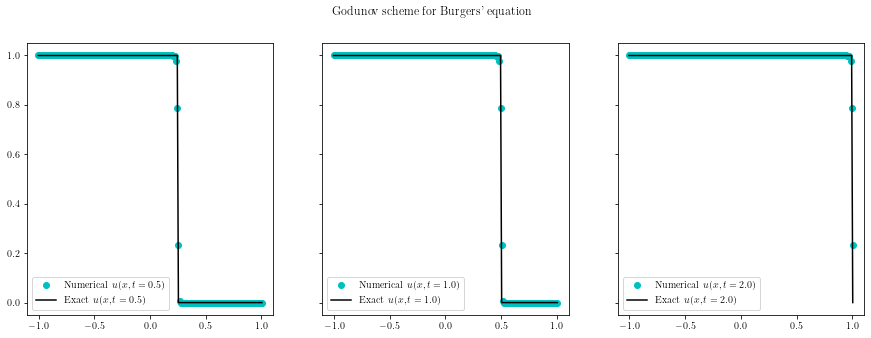

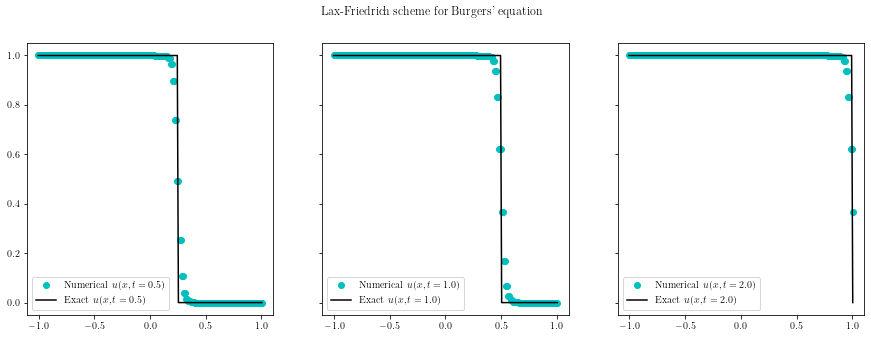

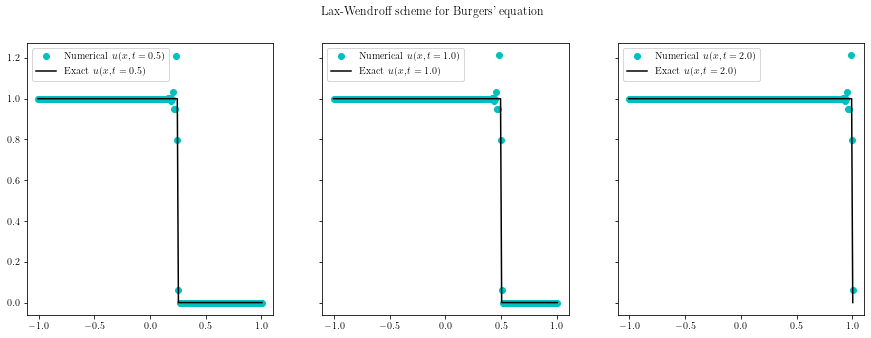

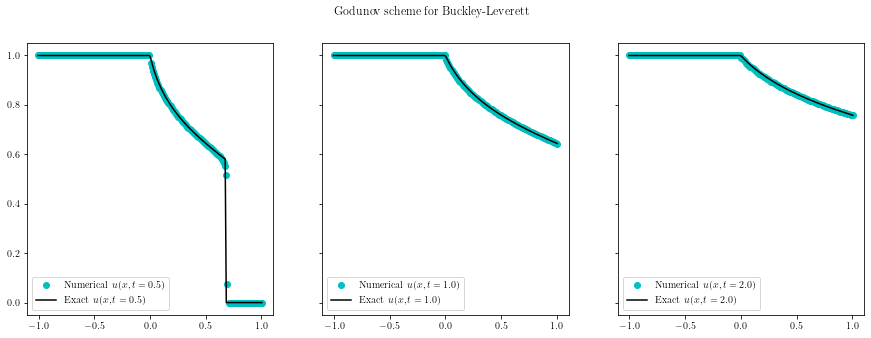

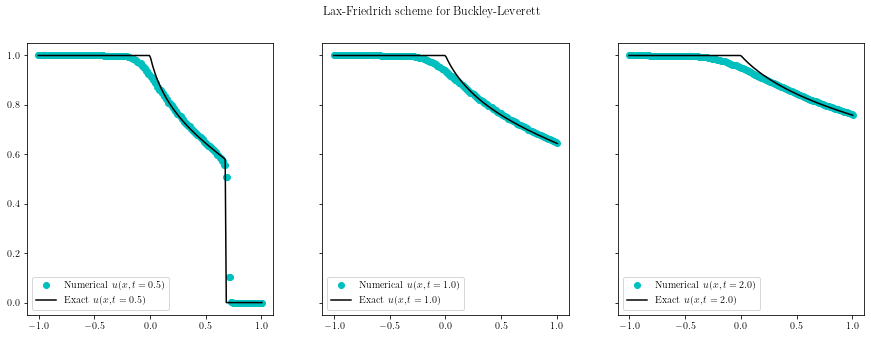

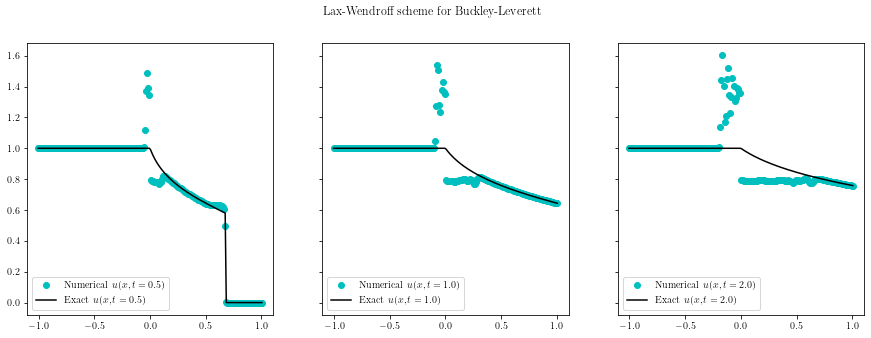

<Figure size 432x288 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

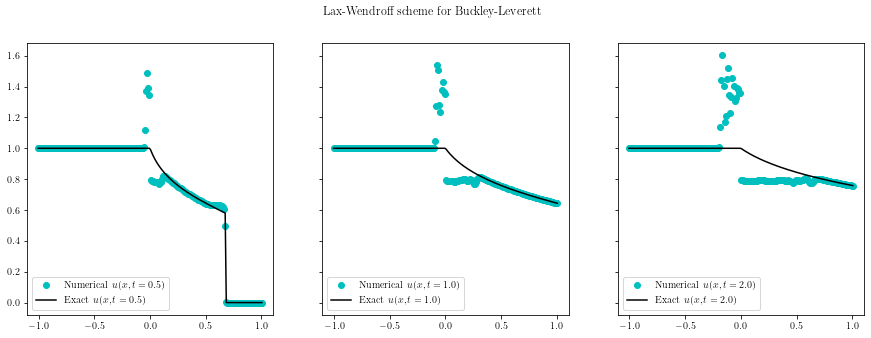

In [22]:
ts = [0.5,1,2]

def outputs(x, u, ex, ts, title, name, save=False):
    plt.clf()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    fig.set_size_inches(15, 5)
    fig.suptitle(title)
    for ax, t in zip([ax1, ax2, ax3], ts):
            j = round(t/dt)
            ax.plot(x,u[j], 'co', label=f"Numerical $u(x,t={round(j*dt, 2)})$", alpha=1)
            ax.plot(x,ex[j], 'k', label=f"Exact $u(x,t={round(j*dt, 2)})$")
#            ax.set_title(f"{title}, $\lambda=${LAMBDA}")
            ax.legend() 
    fig.savefig(f"hw2q3-comparison-{name}-{LAMBDA}.pdf", bbox_inches='tight')
    fig.set_size_inches(15, 5)
    display(fig)
outputs(actualx, u_g1, u_e1, ts, title="Godunov scheme for Burgers' equation", name="f1-go")
outputs(actualx, u_f1, u_e1, ts, title="Lax-Friedrich scheme for Burgers' equation", name="f1-lf")
outputs(actualx, u_w1, u_e1, ts, title="Lax-Wendroff scheme for Burgers' equation", name="f1-lw")

outputs(actualx, u_g2, u_e2, ts, title="Godunov scheme for Buckley-Leverett", name="f2-go")
outputs(actualx, u_f2, u_e2, ts, title="Lax-Friedrich scheme for Buckley-Leverett", name="f2-lf")
outputs(actualx, u_w2, u_e2, ts, title="Lax-Wendroff scheme for Buckley-Leverett", name="f2-lw")

## Error plots (if necessary)

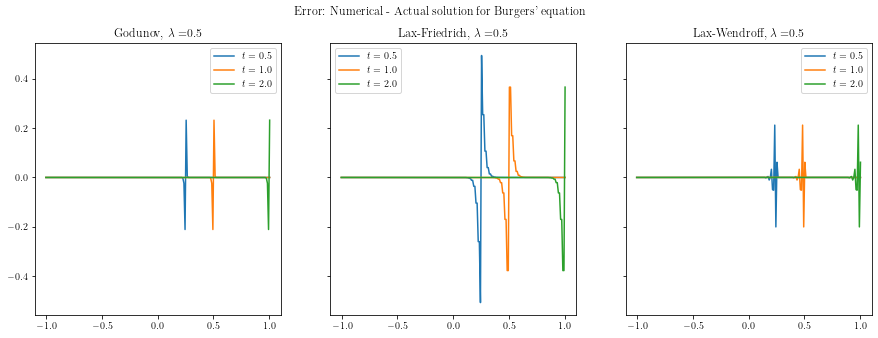

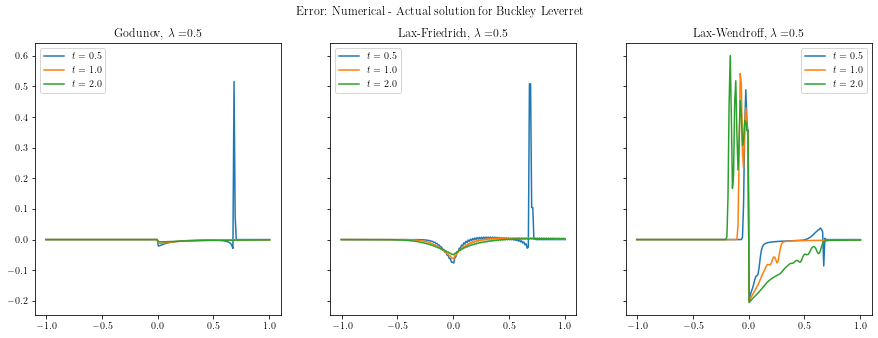

<Figure size 432x288 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

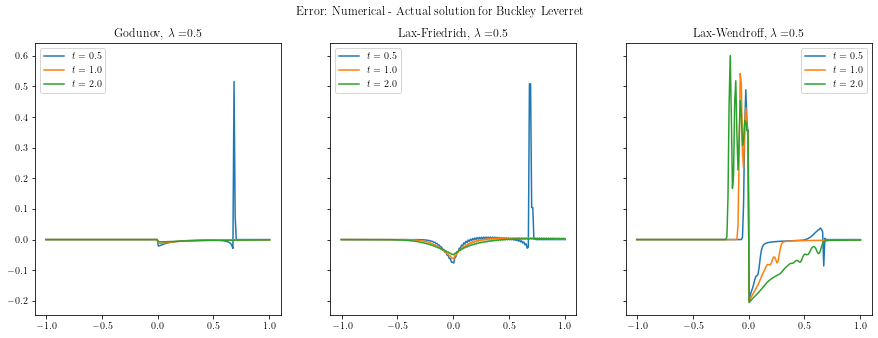

In [23]:
def errorSubplots(uset, xset, exact, ts, name):
    plt.clf()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    fig.set_size_inches(15, 5)
    fig.suptitle("Error: Numerical - Actual solution for "+name)
    for ax, u, x, title in zip([ax1, ax2, ax3], uset, xset, 
        ["Godunov", "Lax-Friedrich", "Lax-Wendroff"]):
        for t in ts:
            j = round(t/dt)
            error_array = u[j] - exact[j]
            ax.plot(x,error_array, label=f"$t={round(j*dt, 2)}$")
            ax.set_title(f"{title}, $\lambda=${LAMBDA}")
            ax.legend() 
    fig.savefig(f"hw2q3-error-{name}-{LAMBDA}.pdf", bbox_inches='tight')
    display(fig)

errorSubplots([u_g1, u_f1, u_w1], [actualx for i in range(3)], u_e1, ts, fluxToName(f1))
errorSubplots([u_g2, u_f2, u_w2], [actualx for i in range(3)], u_e2, ts, fluxToName(f2))